#  Predict Future Sales
## Using Deep Neural Net 


### Load Training Data

In [122]:
import pandas as pd
import numpy as np
import sys

stdout = sys.stdout
#reload(sys)
#sys.setdefaultencoding('utf-8')
#sys.stdout = stdout

#sales_train = pd.read_csv("/Users/djmore/Udacity/machine-learning/projects/capstone/sales_train.csv", sep =',', skiprows=[1,220000], nrows = 100000)
sales_train = pd.read_csv("/Users/djmore/Udacity/machine-learning/projects/capstone/sales_train.csv", sep =',')

sales_data = pd.DataFrame(sales_train)

items = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/capstone/items.csv')
item_categories = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/capstone/item_categories.csv')
shops = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/capstone/shops.csv')


items_data = pd.DataFrame(items)
item_categories_data = pd.DataFrame(item_categories)
shops_data = pd.DataFrame(shops)

### Check if there are blank rows or null values in any data elements

In [123]:
sales_data.isnull().any()


date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

## Describe data, gather basic stats and check for invalid values.

In [124]:
print('Shops               - {}'.format(shops_data['shop_id'].count()))
print('Item Categories     - {}'.format(items_data['item_category_id'].nunique()))
print('Items               - {}'.format(items_data['item_id'].count()))
print('Median item price   - {}'.format(sales_data['item_price'].median()))
print('Min item price      - {}'.format(sales_data['item_price'].min()))
print('Max item price      - {}'.format(sales_data['item_price'].max()))
print('Total Rows          - {}'.format(sales_data['shop_id'].count()))
print('')

Shops               - 60
Item Categories     - 84
Items               - 22170
Median item price   - 399.0
Min item price      - -1.0
Max item price      - 307980.0
Total Rows          - 2935849



### Negative item counts may indicate either returns or buy one get one promo. 
### Analyze which item_category and item_names have negative item counts

In [125]:
print('Negative Item Count - {}'.format((sales_data[sales_data['item_cnt_day'] < 0])['item_cnt_day'].count()))
print('Negative Item Price - {}'.format((sales_data[sales_data['item_price'] < 0])['item_price'].count()))

Negative Item Count - 7356
Negative Item Price - 1


##  Clean up sales data
### Remove negative sales values from data
#### For the purpose of this exercise we will remove all returns data i.e. negative item_price rows.
#### Negative values under item_cnt_day may indicate either a return or promo such as buy one get one free. 
#### Since we have not been any given any information and there are only handle of rows we avoid the complexity of 
#### negative values by removing them.

In [126]:
sales_data = sales_data[sales_data.item_cnt_day > 0] ## Remove rows that have negative item_cnt_day
sales_data = sales_data[sales_data.item_price > 0]   #  Remove rows that have negative item_price

In [127]:
print('Negative Item Count = {}'.format((sales_data[sales_data['item_cnt_day'] < 0])['item_cnt_day'].count()))
print('Negative Item Price = {}'.format((sales_data[sales_data['item_price'] < 0])['item_price'].count()))

Negative Item Count = 0
Negative Item Price = 0


### First let's compute the total sales per month and plot that data.


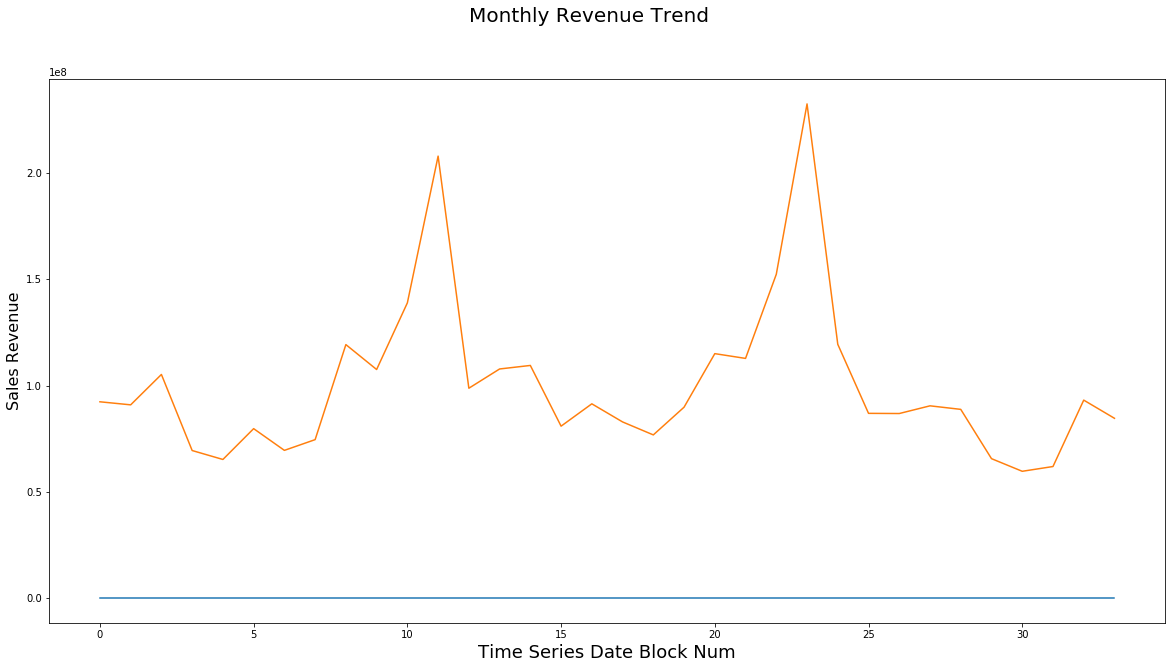

In [149]:
# Create additional dataframe to easy plotting for trend and pattern analysis and pattern 
from matplotlib import pyplot as plt
Revenue = pd.DataFrame({'Monthly Revenue' : sales_data.groupby(['date_block_num'])['sale_revenue_per_day'].sum()}).reset_index()

fig = plt.figure(figsize=(20,10))
plt.plot(Revenue)
fig.suptitle('Monthly Revenue Trend', fontsize=20)
plt.xlabel('Time Series Date Block Num', fontsize=18)
plt.ylabel('Sales Revenue', fontsize=16)
fig.savefig('revenue.jpg')


/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


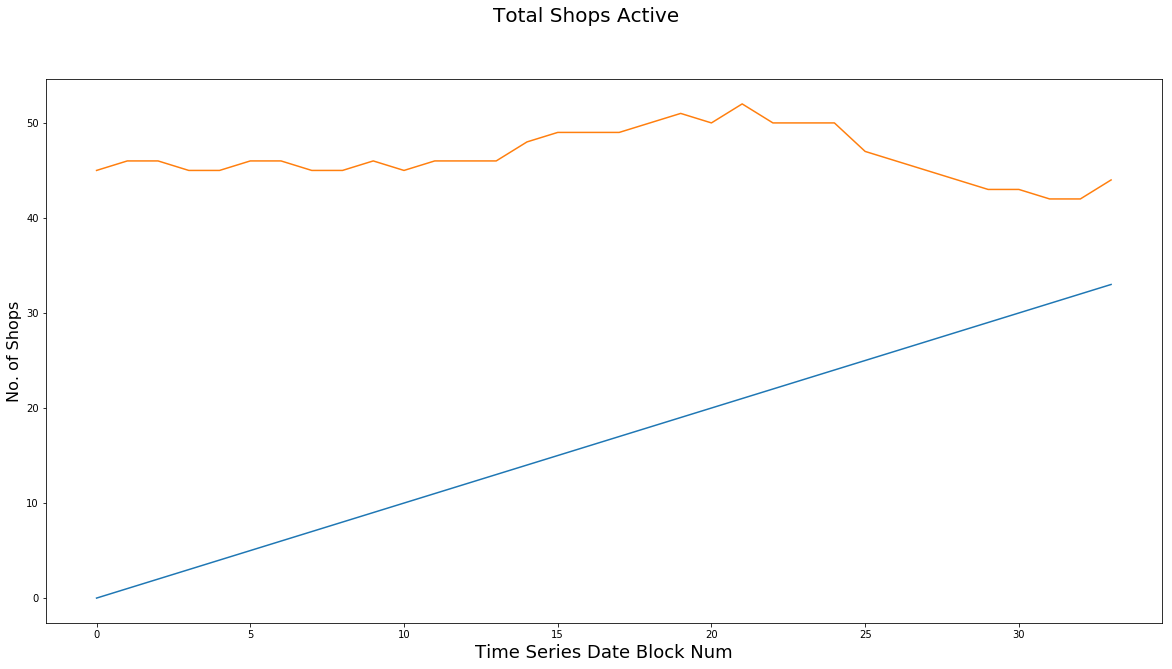

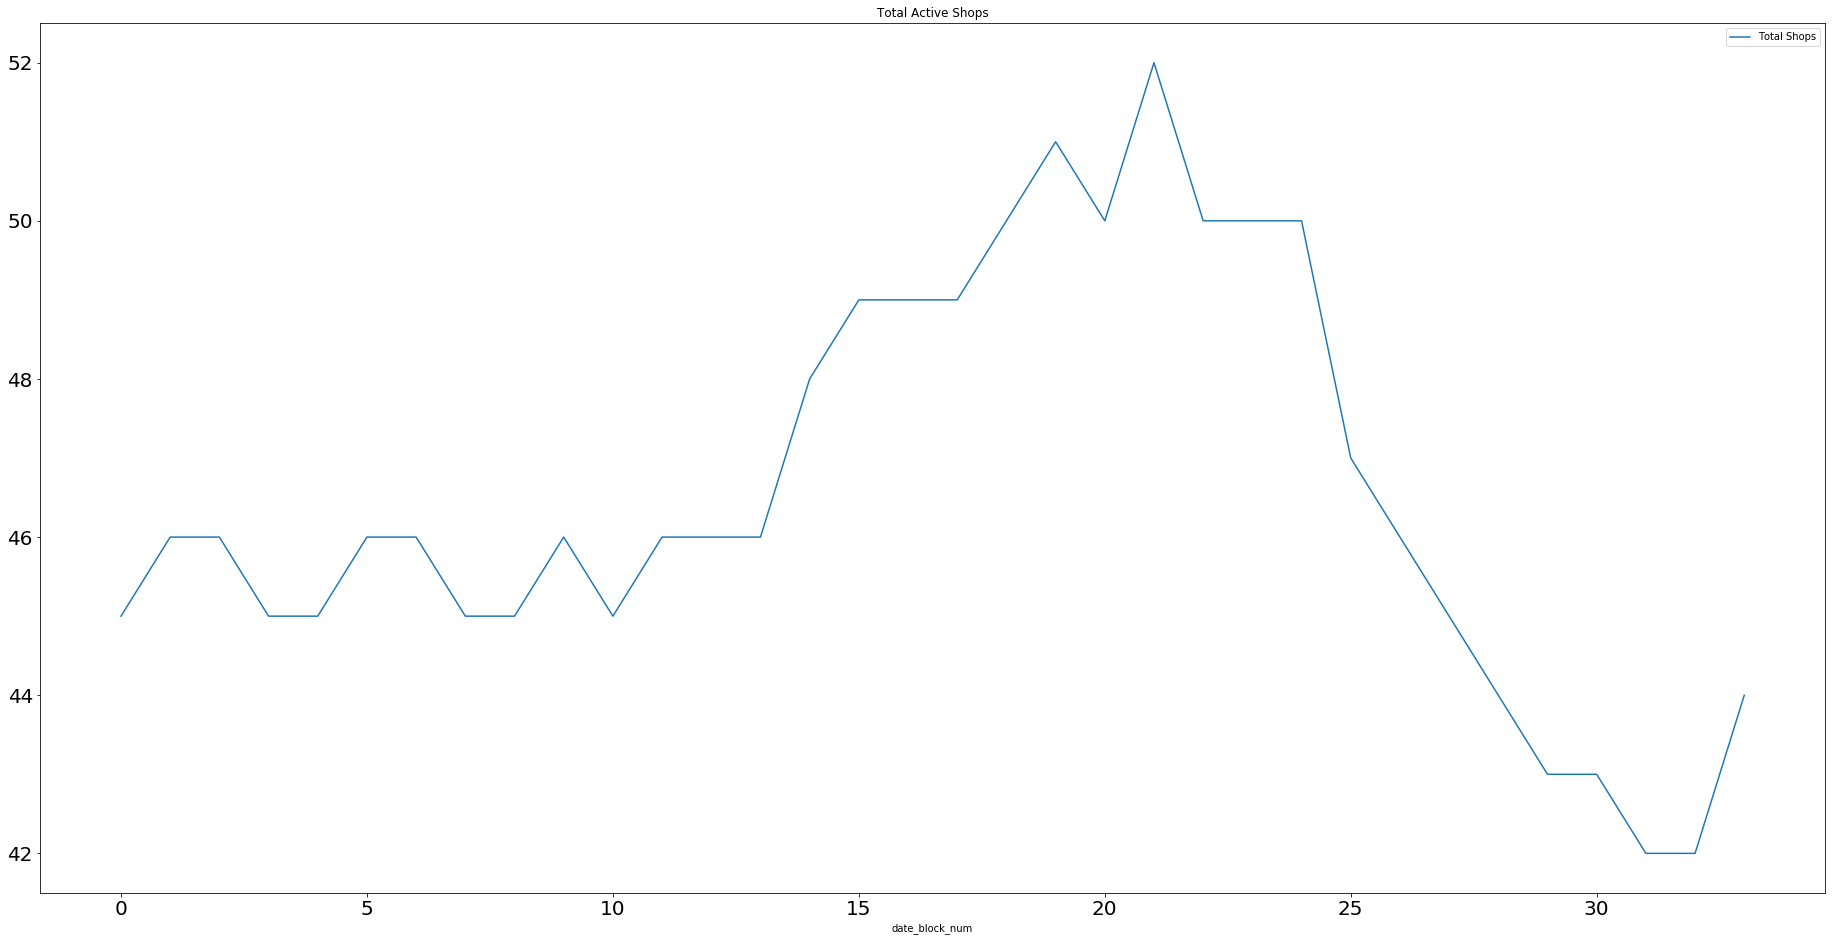

In [148]:
Shops   = pd.DataFrame({'Total Shops' : sales_data.groupby(['date_block_num'])['shop_id'].nunique()}).reset_index()


fig = plt.figure(figsize=(20,10))
plt.plot(Shops)
fig.suptitle('Total Shops Active', fontsize=20)
plt.xlabel('Time Series Date Block Num', fontsize=18)
plt.ylabel('No. of Shops', fontsize=16)
fig.savefig('shops.jpg')

Shops.plot(x="date_block_num", y=['Total Shops'], kind="line", figsize=(32,16),title='Total Active Shops', fontsize=20)

/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


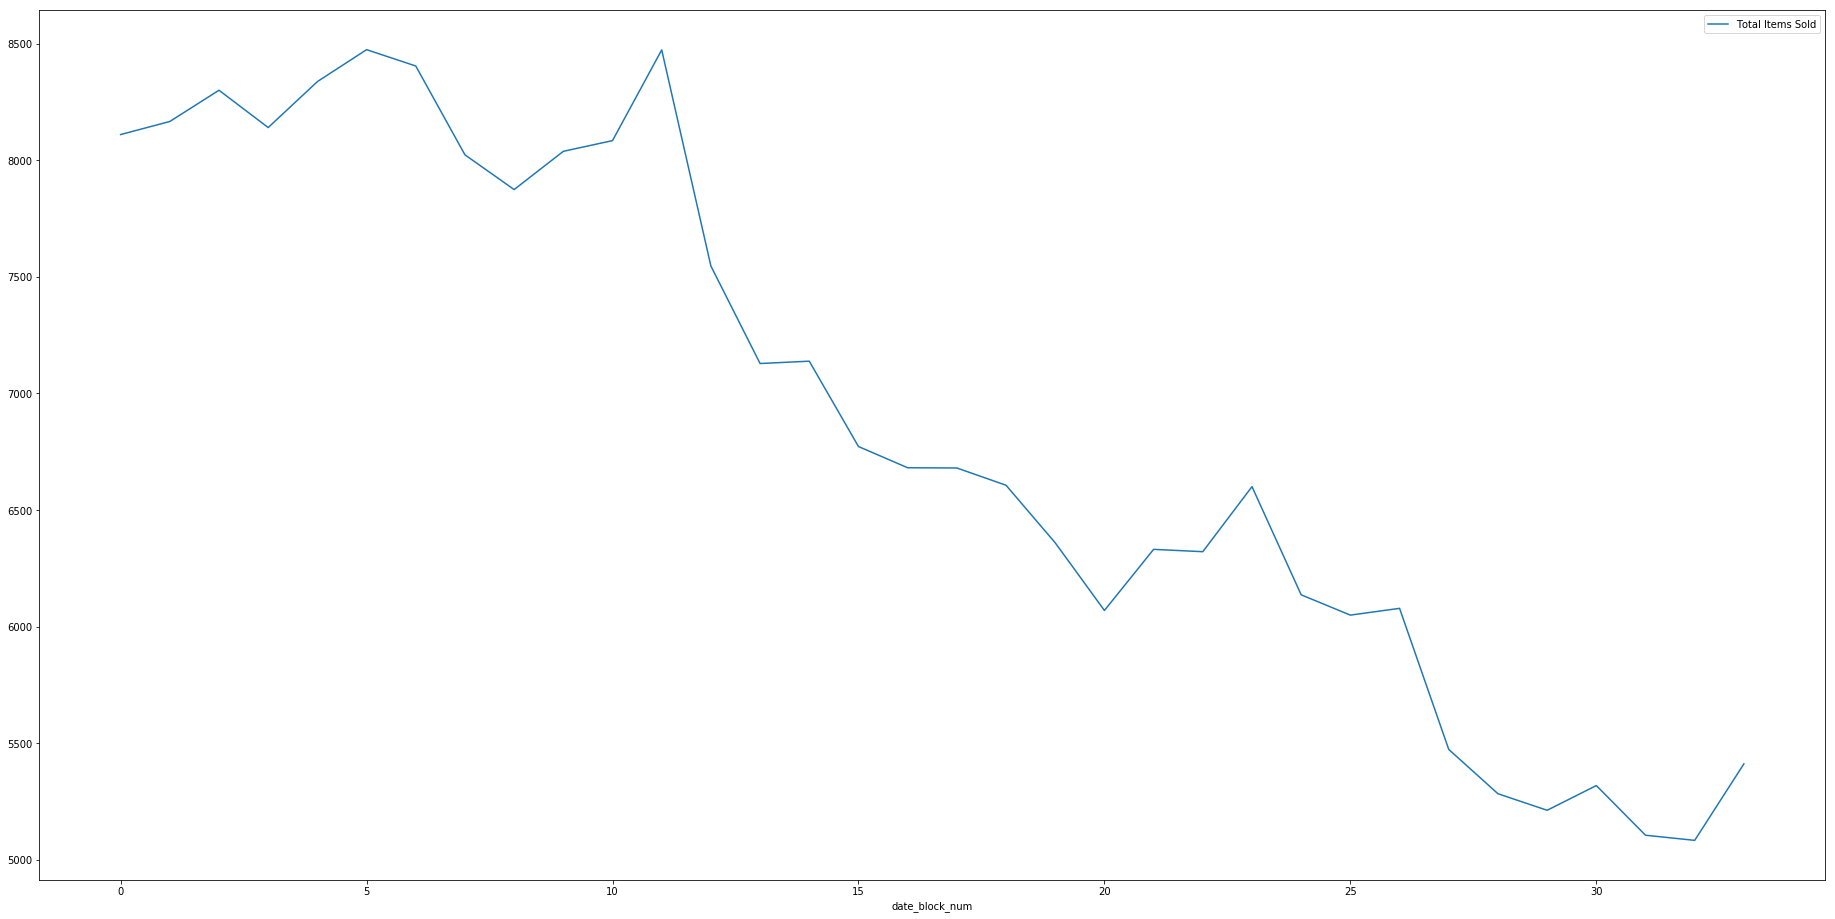

In [156]:
Items   = pd.DataFrame({'Total Items Sold' : sales_data.groupby(['date_block_num'])['item_id'].nunique()}).reset_index()
Items.plot(x="date_block_num", y=['Total Items Sold'], kind="line", figsize=(32,16))

/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


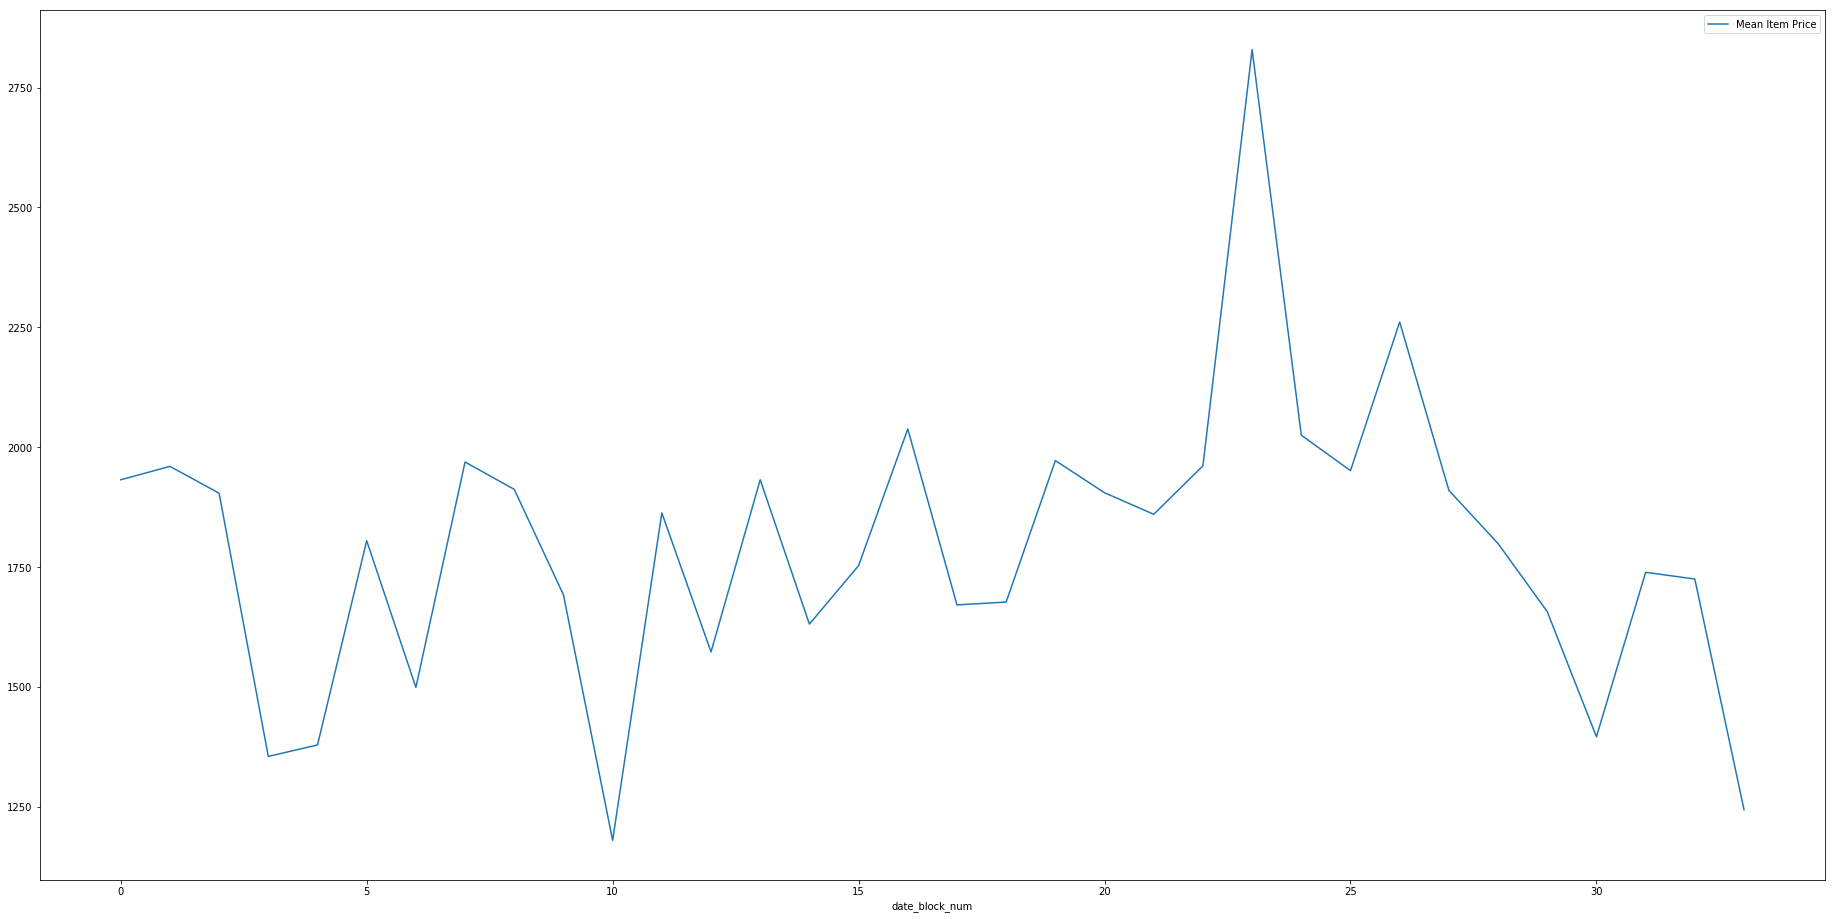

In [137]:
Item_Price = pd.DataFrame({'Mean Item Price' : sales_data.groupby(['date_block_num'])['item_price'].nunique()}).reset_index()

Item_Price.plot(x="date_block_num", y=['Mean Item Price'], kind="line", figsize=(32,16))
plt.show()

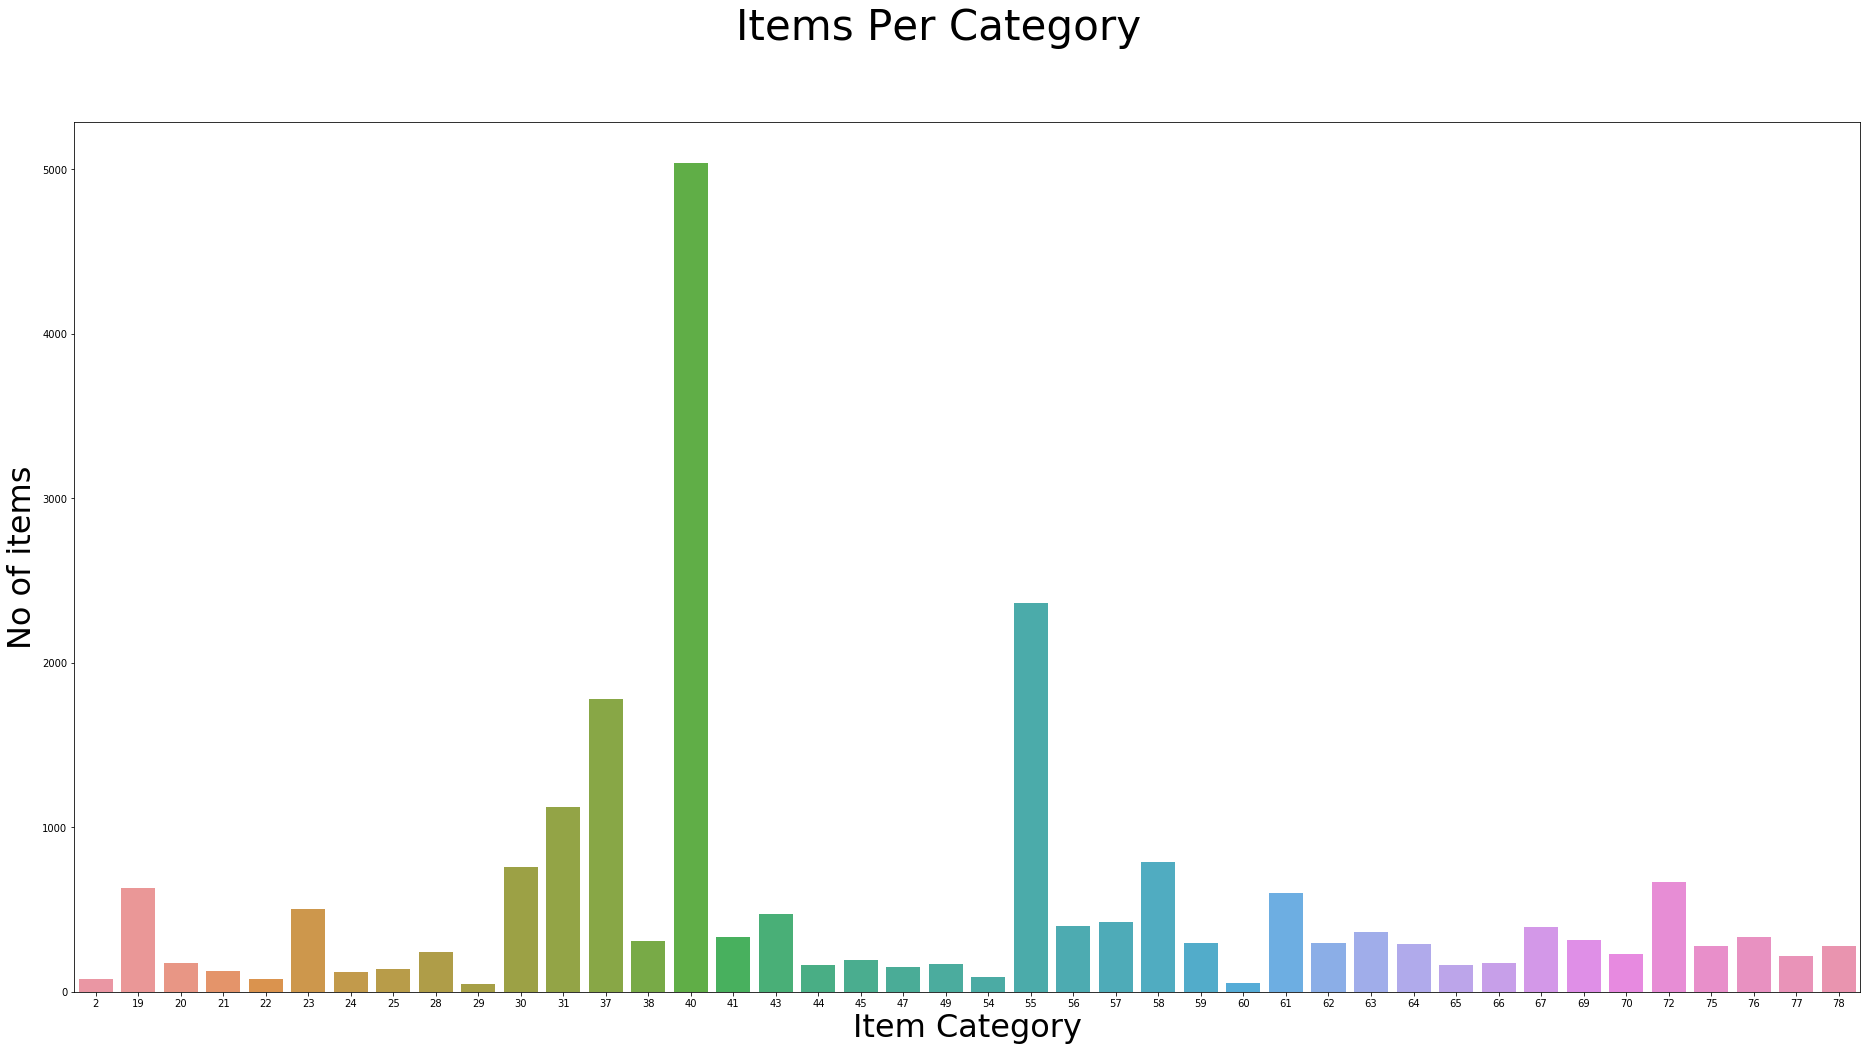

In [158]:
import seaborn as sns

# No. of items per category 
x=items_data.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:42].reset_index()
#x

# plot
fig = plt.figure(figsize=(32,16))
ax = sns.barplot(x.item_category_id, x.item_id)
fig.suptitle('Items Per Category', fontsize=42)
plt.ylabel('No of items', fontsize=32)
plt.xlabel('Item Category', fontsize=32)
fig.savefig('items_per_category.jpg')
plt.show()

### Total sales based on net total items sold

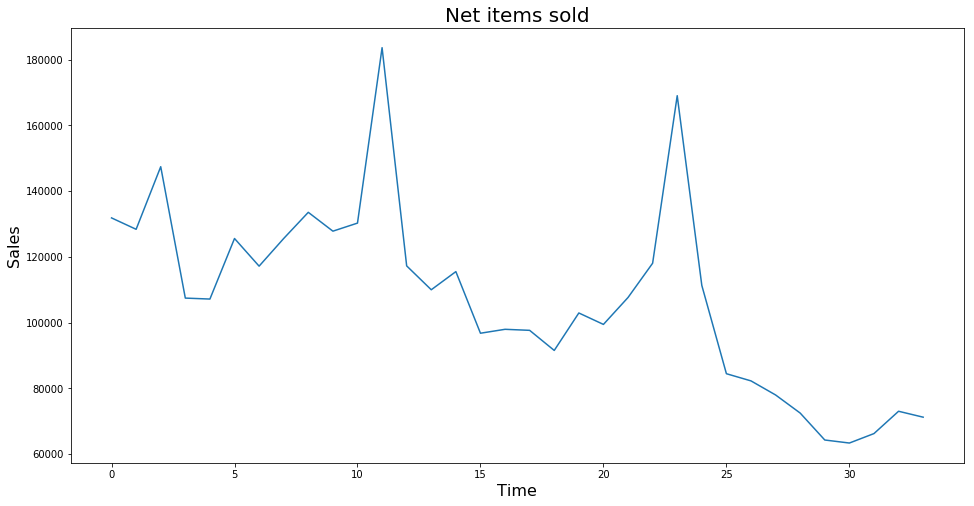

In [159]:
# Total sales based on net total items sold
from matplotlib import pyplot as plt
ts=sales_data.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Net items sold',fontsize=20)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Sales',fontsize=16)
plt.plot(ts);


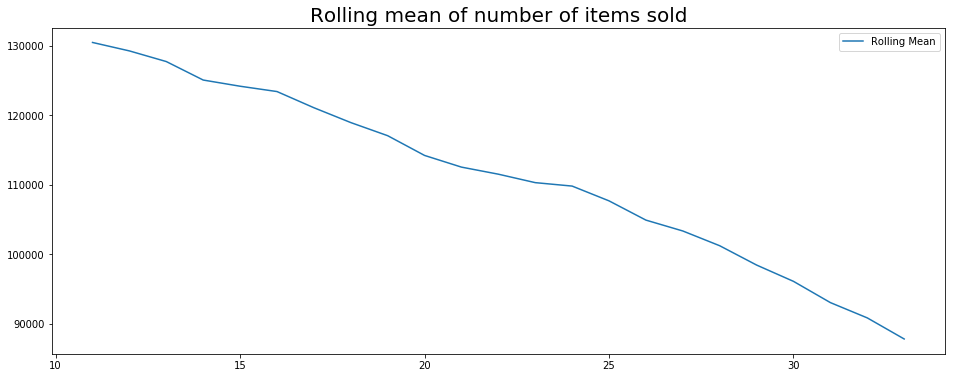

In [163]:
plt.figure(figsize=(16,6))
plt.title('Rolling mean of number of items sold',fontsize=20)
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean')
plt.legend()

In [164]:
### This is an obvious "seasonality" 
### peak sales around a certain of time the year - right around November.
### Mostly - we are seeing a decreasing "Trend" and that's confirmed by the total shops trend as well.
### Let's decompose this into Trend, seasonality and residuals.

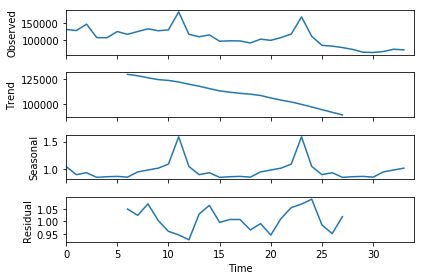

In [171]:
import statsmodels.api as sm

# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

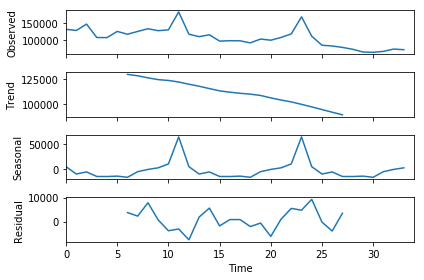

In [173]:
import statsmodels.api as sm
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()


In [185]:
ts1=pd.DataFrame(sales_data.groupby(["date_block_num"])["item_cnt_day"].sum().reset_index())
ts  = ts1.rename(columns={'date_block_num':'ds', 'item_cnt_day':'y'})
ts.head(5)

from fbprophet import Prophet
# FB prophet reqiures a pandas dataframe with 
# date column named as DS and the value column as Y
# 

model = Prophet( yearly_seasonality=True)  
model.fit(ts) 

# predict for next five months in the furure 
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,y
0,0,131850.0
1,1,128382.0
2,2,147438.0
3,3,107439.0
4,4,107147.0


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:531: UserWarning: Discarding nonzero nanoseconds in conversion
  index = _generate_regular_range(start, end, periods, offset)


MemoryError: 

## Break down date column into individual features
### Year, Month, Day, DayofYear, WeekOfYear, DayOfWeek, Quarter
#### This will help us capture weekly, monthly, quarterly and yearly seasonality in the sales data

In [ ]:
# Convert date field to datetime field in pandas
sales_data['date'] = pd.to_datetime(sales_data['date'])
# Extract out date features

sales_data['year'] = sales_data['date'].dt.year
sales_data['month'] = sales_data['date'].dt.month
sales_data['day'] = sales_data['date'].dt.day

sales_data['dayofyear'] = sales_data['date'].dt.dayofyear
sales_data['weekofyear'] = sales_data['date'].dt.weekofyear
sales_data['dayofweek'] = sales_data['date'].dt.dayofweek
sales_data['quarter'] = sales_data['date'].dt.quarter

#sales_data['sale_revenue_per_day'] = sales_data['item_price'] * sales_data['item_cnt_day']

# Sort data in ascending order of time series - year, month,and day
# sales_data.sort_values(['date_block_num','year', 'month', 'day'], ascending=[True,True, True, True],inplace=True)
sales_data.sort_values(['date_block_num','date'], ascending=[True,True],inplace=True)
sales_data.tail(1)

In [ ]:
sales_data.drop(['date'], 1, inplace=True)
sales_data.head(5)

/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


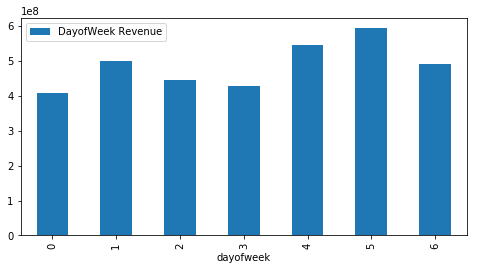

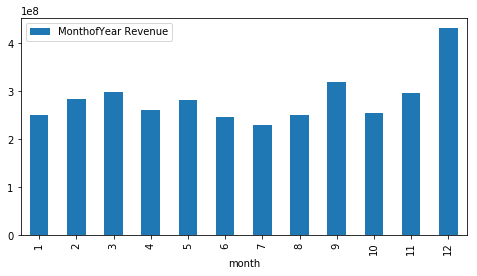

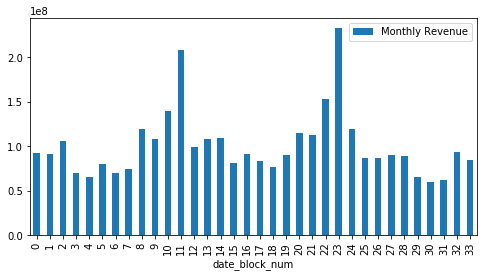

In [125]:
# Week Day seasonality analysis

DayofWeek     = pd.DataFrame({'DayofWeek Revenue' : sales_data.groupby(['dayofweek'])['sale_revenue_per_day'].sum()}).reset_index()
DayofWeek.plot(x="dayofweek", y=['DayofWeek Revenue'], kind="bar", figsize=(8,4))

MonthofYear     = pd.DataFrame({'MonthofYear Revenue' : sales_data.groupby(['month'])['sale_revenue_per_day'].sum()}).reset_index()
MonthofYear.plot(x="month", y=['MonthofYear Revenue'], kind="bar", figsize=(8,4))

Revenue.plot(x="date_block_num", y=['Monthly Revenue'], kind="bar", figsize=(8,4))

In [ ]:
### Prepare Kaggle provided test data
#### Load kaggle test data and append month and year column for prediction purposes.

In [10]:
test = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/capstone/test.csv')
test_data = pd.DataFrame(test)
test_data['month']=11
test_data['date_block_num']=34

#median_item_prices = pd.DataFrame({sales_data.groupby('item_id')['item_price'].median()}).reset_index()
median_item_prices = sales_data.groupby('item_id')['item_price'].median().reset_index()

kaggle_test = pd.merge(test_data, 
                         median_item_prices[['item_id','item_price']], 
                        how='inner',on='item_id')

kaggle_test['date']='01-01-2015'

# Convert date field to datetime field in pandas
kaggle_test['date'] = pd.to_datetime(kaggle_test['date'])
# Extract out date features

kaggle_test['year']        = kaggle_test['date'].dt.year
kaggle_test['month']       = kaggle_test['date'].dt.month
kaggle_test['day']         = kaggle_test['date'].dt.day
kaggle_test['dayofyear']  = kaggle_test['date'].dt.dayofyear
kaggle_test['weekofyear'] = kaggle_test['date'].dt.weekofyear
kaggle_test['dayofweek']  = kaggle_test['date'].dt.dayofweek
kaggle_test['quarter']    = kaggle_test['date'].dt.quarter

# Save kaggle test data to a file
kaggle_test[['date','shop_id','item_id','item_price']].to_csv('kaggle_test.csv')
kaggle_test[['shop_id','item_id','date','item_price']].head(5)

,shop_id,item_id,date,item_price
0,5,5037,2015-01-01,1999.0
1,4,5037,2015-01-01,1999.0
2,6,5037,2015-01-01,1999.0
3,3,5037,2015-01-01,1999.0
4,2,5037,2015-01-01,1999.0


In [16]:
kaggle_test[['shop_id','item_id','date','item_price']].head(5)

,shop_id,item_id,date,item_price
0,5,5037,2015-01-01,1999.0
1,4,5037,2015-01-01,1999.0
2,6,5037,2015-01-01,1999.0
3,3,5037,2015-01-01,1999.0
4,2,5037,2015-01-01,1999.0


In [316]:
for index, row in kaggle_test[['shop_id','item_id']].head(1).iterrows():
    item_frame =  sales_data[(sales_data['item_id'] == row['item_id']) & (sales_data['shop_id'] == row['shop_id'])][['date','shop_id','item_id','item_price']]
    item_frame.sort_values(['date'],ascending=True,inplace=True)
    item_frame.drop(columns=['date'], inplace=True)
    display(item_frame)
    item_price = pd.DataFrame((item_frame['item_price'].rolling(7).mean()).reset_index())
    
    price = item_price['item_price'].tail(1)
    display(price)
    print('Moving Average price of item -> {} in shop -> {}'.format(row['item_id'],round(item_price.tail(1)['item_price'])))

,shop_id,item_id,item_price
1953995,5,5037,2599.0
2150561,5,5037,2599.0
2288631,5,5037,1999.0
2288630,5,5037,1999.0
2335446,5,5037,1999.0
2719247,5,5037,1499.0
2860998,5,5037,749.5
2618926,5,5037,1299.0
2704068,5,5037,1499.0
2335447,5,5037,1999.0


12    1220.571429
Name: item_price, dtype: float64

Moving Average price of item -> 5037 in shop -> 12    1221.0
Name: item_price, dtype: float64


In [15]:
# Moving Average Price from last 30 days


#for index, row in kaggle_test[['shop_id','item_id']].tail(50).iterrows():
    
#    item_frame =  sales_data[(sales_data['item_id'] == row['item_id']) & (sales_data['shop_id'] == row['shop_id'])][['date','shop_id','item_id','item_price']]
#    item_frame.sort_values(['date'],ascending=True,inplace=True)
#    display(item_frame.head(1))
    
#    if (item_frame.empty and row['item_id'] in sales_data[['item_id']]):
#        item_frame = sales_data[['item_id'] == row['item_id']].groupby('item_id')['item_price'].median().reset_index()
#        print(item_frame['item_price'].rolling(30).mean())
#        display(item_frame.head(1))
#    else:
#        print(item_frame['item_price'].rolling(30).mean())


#print(item_frame['item_price'].isnull().count())
#print('shop_id - {} item_id - {} item_price - {}'.format(row['shop_id'],row['item_id'],item_price))

## Scale Numerical columns item_price and item_cnt_day

In [11]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numerical = ['item_price', 'item_cnt_day']

sales_minmax_transform = pd.DataFrame(data = sales_data)
sales_minmax_transform[numerical] = scaler.fit_transform(sales_data[numerical])

In [13]:
# Show an example of a record with scaling applied to sales_minmax_transform
display(sales_minmax_transform.head(5))
display(sales_minmax_transform.tail(5))

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,dayofyear,weekofyear,dayofweek,quarter
7554,0,19,18976,0.001295,0.0,2013,1,1,1,1,1,1
7644,0,19,18284,0.000646,0.0,2013,1,1,1,1,1,1
7646,0,19,18320,0.000646,0.0,2013,1,1,1,1,1,1
7647,0,19,18329,0.000971,0.0,2013,1,1,1,1,1,1
7694,0,19,19367,0.001295,0.0,2013,1,1,1,1,1,1


,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,dayofyear,weekofyear,dayofweek,quarter
2935638,33,25,7724,0.006166,0.000000,2015,12,10,344,50,3,4
2935648,33,25,7894,0.007435,0.000000,2015,12,10,344,50,3,4
2935659,33,25,7657,0.001133,0.000461,2015,12,10,344,50,3,4
2935679,33,25,7842,0.005192,0.000000,2015,12,10,344,50,3,4
2935770,33,25,7071,0.003243,0.000461,2015,12,10,344,50,3,4


In [15]:
# Show an example of a record with scaling applied to sales_data
sales_data.tail(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,dayofyear,weekofyear,dayofweek,quarter
2935679,33,25,7842,0.005192,0.000000,2015,12,10,344,50,3,4
2935770,33,25,7071,0.003243,0.000461,2015,12,10,344,50,3,4


## Prepare Train-Test-Split Data
###  We will use 
  - First 31 months of data as training data 
  - 32nd months data as validation data
  - 33rd month data as test data

In [18]:
max_date_block_num=sales_data['date_block_num'].max()

X_train = sales_data[sales_data.date_block_num < max_date_block_num - 14]
#X_train = sales_data[sales_data.date_block_num == 0]
y_train = X_train['item_cnt_day']
del X_train['item_cnt_day']

X_val = sales_data[(sales_data.date_block_num >= max_date_block_num - 10) & (sales_data.date_block_num <= max_date_block_num - 2)] 
#X_val = sales_data[(sales_data.date_block_num >= 18) & (sales_data.date_block_num <= 20)] 
y_val = X_val['item_cnt_day']
del X_val['item_cnt_day']

X_test = sales_data[sales_data.date_block_num > max_date_block_num - 1]
#X_test = sales_data[sales_data.date_block_num == 33]
y_test = X_test['item_cnt_day']
del X_test['item_cnt_day']


In [20]:
print("Max Date Block Num              = {} ".format(max_date_block_num))
print('Training Date Block Num from    0 to {} '.format((max_date_block_num-15)))
print("Validation Date Block Num from  {} to {} ".format((max_date_block_num-11),(max_date_block_num - 2)))
print("Testing Date Block Num from     {} to {}".format((max_date_block_num-1),(max_date_block_num)))
X_train.shape[1]

Max Date Block Num              = 33 
Training Date Block Num from    0 to 18 
Validation Date Block Num from  22 to 31 
Testing Date Block Num from     32 to 33


11

## Implement Neural Net Model

### Define the Model Architecture
#### With Embeddings

3 is the embedding dimension - i.e. the 5 categories will be represented as a 3 dimensional vector in the embedding space. You can think of it as dimensionality reduction from the one-hot encoding representation of that category.

Top right of page 4 here has some more commentary on choosing the embedding dimension, but the main takeaway is that it's selected as a hyperparameter through experimentation/cross-validation.
Hi Chetan, really good to hear!

Keras makes it not too bad to do this. When you define the NN, you can name layers as below:

model = Sequential() 
model.add(Merge(models, mode='concat', name='embedding_layer'))

Then after training the NN, you can define a new model that extracts the features in that layer. The :-16 here just restricts the output to the embedded features, excluding the non-categorical ones.

embedded_features_model = \ 
Model(inputs=NN.input, outputs=NN.get_layer('embedding_layer').output) 
embedded_features_train = embedded_features_model.predict(proc_X_train_f)[:,:-16]

In [68]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Embedding


# Embedding
max_features = 23000
maxlen = X_train.shape[1]
embedding_size = 200

# define the model
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(1, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1, activation='relu'))
model.add(Dropout(0.8))
#model.add(Dense(1, activation='softmax'))
model.add(Dense(1, activation="sigmoid"))
#model.add(Activation("softmax"))

# summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 11, 200)           4600000   
_________________________________________________________________
flatten_9 (Flatten)          (None, 2200)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 2201      
_________________________________________________________________
dropout_21 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 2         
_________________________________________________________________
dropout_22 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 2         
Total para

### Compile the Model

In [69]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [70]:
print(X_test.shape)
print(y_test.shape)

(53386, 11)
(53386,)


### Evaluate test accuracy

In [71]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 89.4130%


### Train the Model

In [72]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='predictsales.model.best.hdf5', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=1000, epochs=3, validation_data=(X_val, y_val), 
                 callbacks=[checkpointer],verbose=1)

Train on 1862448 samples, validate on 637451 samples
Epoch 1/3
1862448/1862448 [==============================] - 113s 61us/step - loss: 0.0940 - acc: 0.8995 - val_loss: 0.0058 - val_acc: 0.9008

Epoch 00001: val_loss improved from inf to 0.00584, saving model to predictsales.model.best.hdf5
Epoch 2/3
1862448/1862448 [==============================] - 113s 60us/step - loss: 0.0182 - acc: 0.8995 - val_loss: 0.0012 - val_acc: 0.9008

Epoch 00002: val_loss improved from 0.00584 to 0.00117, saving model to predictsales.model.best.hdf5
Epoch 3/3
1862448/1862448 [==============================] - 156s 84us/step - loss: 0.0054 - acc: 0.8995 - val_loss: 3.4707e-04 - val_acc: 0.9008

Epoch 00003: val_loss improved from 0.00117 to 0.00035, saving model to predictsales.model.best.hdf5


### Load the Model with the Best Classification Accuracy on the Validation Set

In [65]:
# load the weights that yielded the best validation accuracy
model.load_weights('predictsales.model.best.hdf5')

### Calculate the Model Loss or Accuracy on the Test Set

In [66]:
# evaluate test accuracy
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
#accuracy = 100*score[1]

# print test accuracy
print('Accuracy: %f ' % (accuracy*100))
#print('Test accuracy: %.4f%%' % accuracy)

Accuracy: 89.412955 


### Actual Predictions from the model

In [111]:
#predictions = model.predict(X_test)
print(predictions)

[[ 0.00298043]
 [ 0.00295874]
 [ 0.0023589 ]
 ..., 
 [ 0.00838823]
 [ 0.00812059]
 [ 0.00906968]]


### Define the Neural Net Model
#### With Embeddings and Convolutional Layer

In [108]:
#predictions = model.predict(X_test)
print(predictions)

[[ 0.00298043]
 [ 0.00295874]
 [ 0.0023589 ]
 ..., 
 [ 0.00838823]
 [ 0.00812059]
 [ 0.00906968]]


In [109]:
print(y_test)

2882396    0.000000
2882398    0.000000
2882425    0.000000
2882432    0.000000
2882471    0.000000
2882555    0.000000
2882599    0.000000
2882606    0.000000
2882654    0.000000
2882737    0.000000
2882742    0.000000
2882767    0.000000
2882772    0.000000
2882774    0.000000
2882784    0.000000
2882788    0.000000
2882843    0.000000
2882850    0.000000
2882852    0.000000
2882861    0.000000
2882863    0.000000
2882874    0.000000
2882926    0.000000
2882955    0.000000
2883023    0.000000
2883073    0.000000
2883074    0.000000
2883091    0.000000
2883130    0.000000
2883178    0.000000
             ...   
2934740    0.000000
2934822    0.000000
2934829    0.000000
2934849    0.000000
2934857    0.000000
2934891    0.000000
2934925    0.000000
2934972    0.000461
2934989    0.000000
2935057    0.000000
2935059    0.000000
2935067    0.000000
2935189    0.000000
2935201    0.000000
2935270    0.000000
2935324    0.000000
2935340    0.000000
2935343    0.000000
2935344    0.000000


In [ ]:

from keras.layers import Conv1D, MaxPooling1D

# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='rmse',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val))
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)